
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Modal bias: demonstrating and calculating model bias with a simple predictive machine learning method

#### Bader Al Shammasi 

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering


_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

Estimating model bias is a key step towards building an accurate machine learning model, however, bias cannot be calculated or represented with a single number. Hence, the objective of this project is to create a workflow that addresses this issue by building a simple predictive machine learning model which provides several statistical metrics to collectively demonstrate and calculate bias. 

This workflow analyzes two linear regression models, one that was fitted into a non-linear dataset, and the other into a linear dataset. The model predicts permeability from a set of porosity and permeability samples. It was expected that the non-linear dataset's model will show higher residual since bias by definition is the systematic error between the model's prediction and the true value. Moreover, it was learned that the more the model was underfitting the dataset, the higher the bias was. 

In real-life applications in the oil and gas industry, data is almost always collected in a manner that preserves resources rather than collecting more data to approach the sample population. With that in mind, it is essential to address model bias by analysing the prediction errors of future models to enhance the overall performance.

### Import Packages


In [119]:
import pandas as pd                               # used for dataframes
import numpy as np                                # arrays and matrix math
from sklearn.linear_model import LinearRegression # used to fit a linear regression model
import matplotlib.pyplot as plt                   # used for plotting purposes
from sklearn.metrics import mean_squared_error    # used to calculate MSE
import scipy.stats as st                          # used for statistical methods

### Workflow:

### Step (1): Load Data

- Note: Dr. Michael Pyrcz's code for [SubsurfaceDataAnalytics_LinearRegression](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_LinearRegression.ipynb) was used in this workflow.

- The workflow uses [nonlinear_facies_v1.csv](https://github.com/GeostatsGuy/GeoDataSets/blob/master/nonlinear_facies_v1.csv) dataset from Dr.Pyrcz's GitHub repository
    - The model will be using the following features:

        * **Porosity (%)** - percentage of void space in a rock
        * **Permeability (mD)** - the ability of fluid flow in a rock


In [122]:

df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v1.csv") # load data from Dr. Pyrcz's GitHub repository
df.head() # Shows the first 5 rows of the .csv


,Unnamed: 0,Por,Perm,Facies
0,0,5.884729,777.927713,3
1,1,5.579639,741.831286,3
2,2,3.732165,720.502871,3
3,3,3.081551,545.878794,3
4,4,9.079613,888.300959,3


- Columns that will not be used will be deleted using the below function

In [125]:
columns_to_delete = ['Unnamed: 0', 'Facies'] # Deletes columns from the .csv file
for col in columns_to_delete:
    if col in df.columns:
        del df[col]
df.head()

,Por,Perm
0,5.884729,777.927713
1,5.579639,741.831286
2,3.732165,720.502871
3,3.081551,545.878794
4,9.079613,888.300959


### Step (2): Show Summary Statistics
This step is useful to to have a general visualization of the data to look for off values such as negatives or outliers

In [127]:
df.describe().transpose() # the describe function is used to show summary statistics while the transpose reduces the visualization's # of rows

,count,mean,std,min,25%,50%,75%,max
Por,1700.0,15.900026,7.241663,0.0,10.000000,18.343307,21.753840,30.0
Perm,1700.0,982.424677,220.903674,10.0,847.051401,1065.011848,1154.053445,1200.0


### Step (3): Visualize the data

- A permeability-porosity transform is better represented with the log of permeability
- Before plotting the data, arrays of permeability and log of permeability data has to be defined and then extracted as the $y$ parameter:

In [132]:
perm = df["Perm"]                                           # defines permeability as an array
df['logpermeability'] = np.log(df['Perm'])                  # defines log of permeability as an array
xname = 'Por'; xlabel = 'Porosity'; xunit = '%'
yname = 'logpermeability'; ylabel = 'Permeability'; yunit = 'mD'
xmin = 0; xmax = 35; ymin = 2; ymax = 8
y = df[yname].values                                        # extract the array into y
x = df[xname].values                                 

- The model will be visualized by plotting porosity vs log of permeability below:

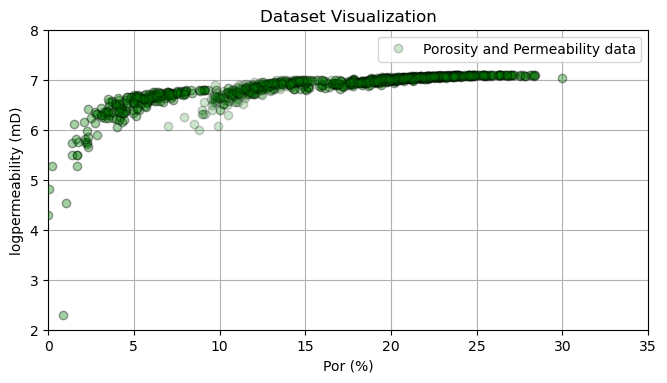

In [135]:
plt.figure(figsize=(6, 3))                                  # plotting the model
plt.subplot(111)                                         
plt.plot(x, y, 'o', label='Porosity and Permeability data', color = 'green', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.title('Dataset Visualization')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel(yname + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

- The visualization clearly shows the non-linearity of the dataset 

### Step (3): Modify Sample Data to Create a Linear Dataset

- The below function will be used to omit data to reduce the non-linearity of the dataset and create the "linear" dataset

In [139]:
threshold_perm = 6.7                                       # Eliminate data points where log of permeability is less than 6.7
filtered_df = df[df[yname] >= threshold_perm]

y_filtered = filtered_df[yname].values                      # Updating the arrays with the filtered values
x_filtered = filtered_df[xname].values                      # Updating the arrays with the filtered values

- Plotting both datasets:

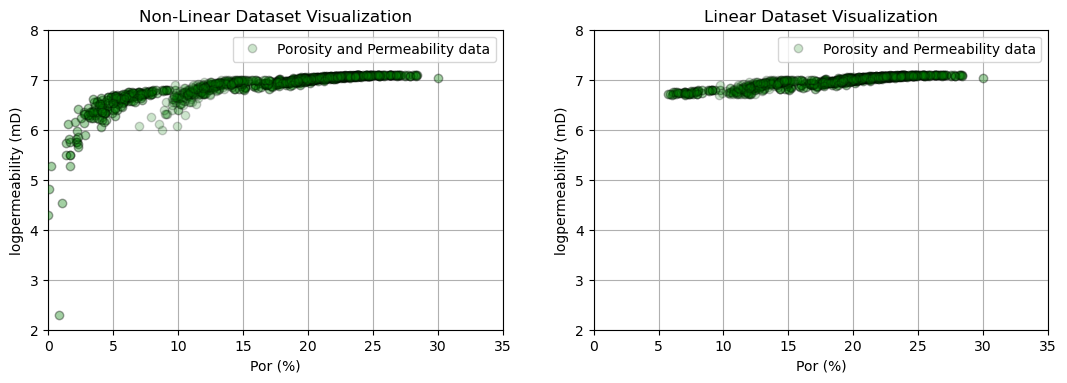

In [141]:
plt.figure(figsize=(10, 3))
plt.subplot(121)                                            # plot the non-linear dataset model
plt.plot(x, y, 'o', label='Porosity and Permeability data', color = 'green', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.title('Non-Linear Dataset Visualization')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel(yname + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(122)                                            # plot the linear dataset model
plt.plot(x_filtered, y_filtered, 'o', label='Porosity and Permeability data', color = 'green', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.title('Linear Dataset Visualization')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel(yname + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

### Step (5): Build a Linear Regression Model

A linear regression model will be used to predict the log of permeability from porosity.
- A linear regression model is a parametric model that uses the form of $y = b_1 x + b_0$
    - $b_1$ is the model's slope
    - $b_0$ is the y-intercept
- The model's parameters are optimized by minimizing the error on the training data in an operation called "Least Squares":
  $$Minimize[\sum_{i=1}^n (y_i - (\sum_{\alpha = 1}^m b_{\alpha} x_{\alpha} + b_0))^2]$$

The slope and y-intercept of both models will be calculated using the ```st.linregress```function:

In [146]:
slope, intercept, r_value, p_value, std_err = st.linregress(x,y) # instantiate and fit a linear regression model in the non-linear dataset

print('The non-linear dataset model parameters are, slope (b1) = ' + str(round(slope,2)) + ', and the intercept (b0) = ' + str(round(intercept,1)))

slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(x_filtered,y_filtered) # instantiate and fit a linear regression model in the linear dataset

print('The linear dataset model parameters are, slope (b1) = ' + str(round(slope2,2)) + ', and the intercept (b0) = ' + str(round(intercept2,1)))

The non-linear dataset model parameters are, slope (b1) = 0.04, and the intercept (b0) = 6.3
The linear dataset model parameters are, slope (b1) = 0.02, and the intercept (b0) = 6.6


- Plotting both linear regression models:

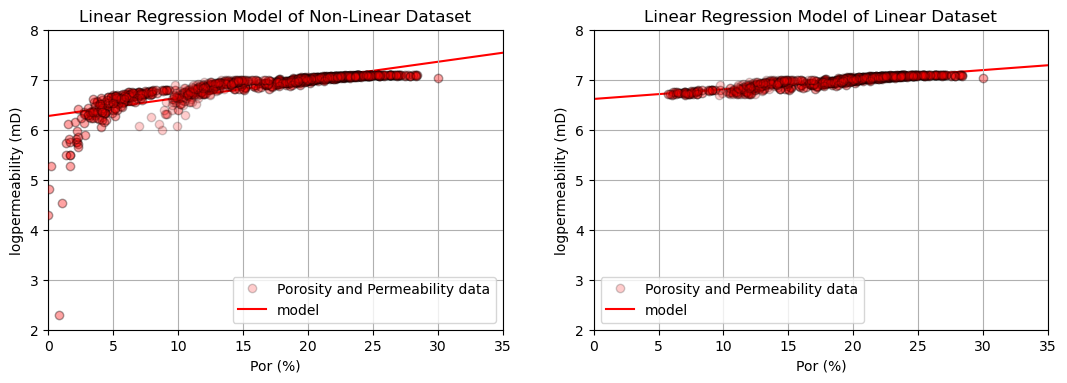

In [148]:
plt.figure(figsize=(10, 3))
x_values = np.linspace(xmin,xmax,100)                       # return an array of density values 
y_model = slope * x_values + intercept                      # apply our linear regression model to estimate at the training data values
plt.subplot(121)                                            # plot the non-linear dataset model
plt.plot(x, y, 'o', label='Porosity and Permeability data', color = 'red', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.plot(x_values, y_model, label='model', color = 'red',zorder=1)
plt.title('Linear Regression Model of Non-Linear Dataset')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel(yname + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

x_values = np.linspace(xmin,xmax,100)                       # return an array of density values 
y_model = slope2 * x_values + intercept2                    # apply our linear regression model to estimate at the training data values
plt.subplot(122)                                            # plot the linear dataset model
plt.plot(x_filtered, y_filtered, 'o', label='Porosity and Permeability data', color = 'red', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.plot(x_values, y_model, label='model', color = 'red',zorder=1)
plt.title('Linear Regression Model of Linear Dataset')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel(yname + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

### Step (6): Calculate Predictions and Results

#### Predictions:

- The model's predictions are plotted below:

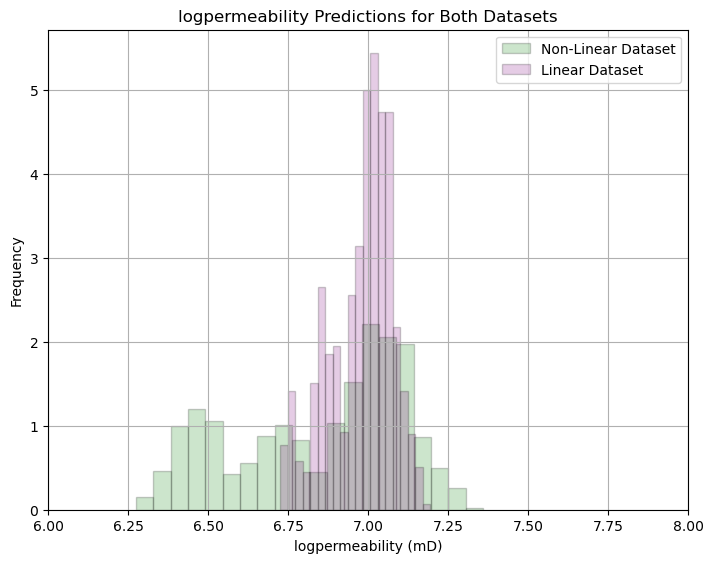

In [154]:
y_hat2 = slope2 * x_filtered + intercept2    # defining the prediction equation for the linear dataset
y_hat = slope * x + intercept                # defining the prediction equation for the non-linear dataset

plt.subplot(111)                             # plotting the histogram
plt.hist(y_hat, alpha = 0.2, color = 'green', edgecolor = 'black', bins=20,label='Non-Linear Dataset', density = True)
plt.hist(y_hat2, alpha = 0.2, color = 'purple', edgecolor = 'black', bins=20, label = "Linear Dataset", density = True)
plt.xlabel(yname + ' (' + yunit + ')'); plt.ylabel('Frequency'); plt.title(yname + ' Predictions for Both Datasets')
plt.grid()
plt.legend()
plt.xlim([6,8])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Results:

- The residuals of predictions from both models are below:

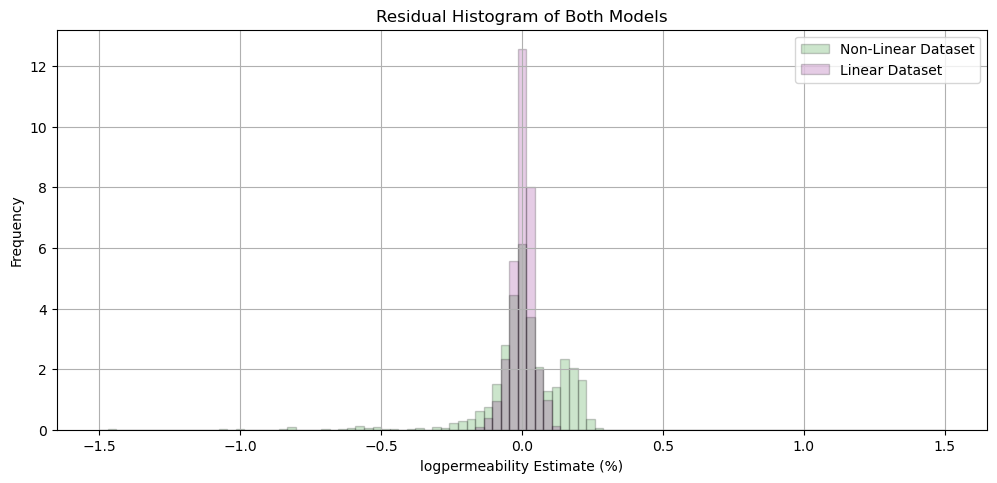

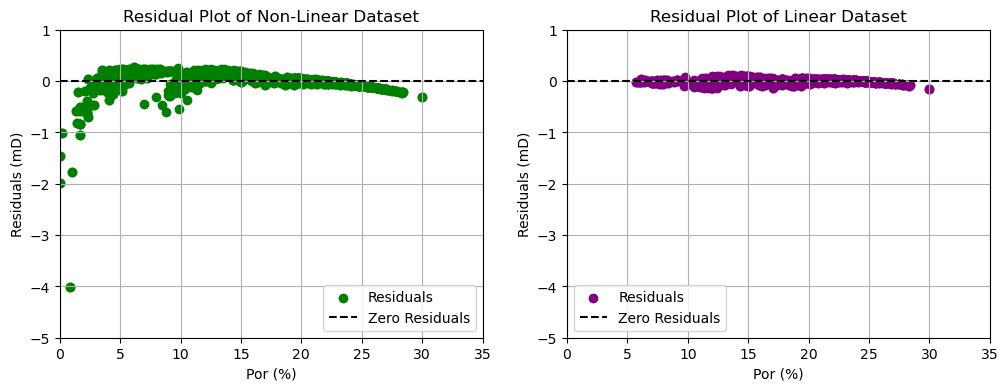

Non-linear dataset mean residual (bias): 1.6718652606120004e-16
Non-linear dataset mean squared error: 0.0506
Non-linear dataset correlation coefficient is =  0.76
Non-linear dataset r-squared value: 0.58
Linear dataset mean residual (Bias): -1.3375860632010867e-15
Linear dataset mean squared error: 0.0016
Linear dataset correlation coefficient is =  0.93
Linear dataset r-squared value: 0.86


In [157]:
residual = y-y_hat                            # defining the residual equation for the non-linear dataset
residual2 = y_filtered- y_hat2                # defining the residual equation for the linear dataset

plt.figure(figsize=(9.3,4))                   # Plotting the residuals histogram for both models
plt.subplot(111)
plt.hist(residual, alpha = 0.2, color = 'green', edgecolor = 'black', bins = np.linspace(-1.5,1.5,100),label='Non-Linear Dataset', density = True)
plt.hist(residual2, alpha = 0.2, color = 'purple', edgecolor = 'black', bins = np.linspace(-1.5,1.5,100), label = "Linear Dataset", density = True)
plt.title("Residual Histogram of Both Models"); plt.xlabel(yname + ' Estimate (%)');plt.ylabel('Frequency'); plt.grid()
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

mean_residual = residual.mean()               # Calculating the mean of the residuals for the non-linear dataset
mean_residual2 = residual2.mean()             # Calculating the mean of the residuals for the linear dataset

plt.figure(figsize=(12,4))                    # Plotting the residuals plot for the non-linear model
plt.subplot(121)
plt.scatter(x, residual, label='Residuals', color='green')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel('Residuals (mD)')
plt.title('Residual Plot of Non-Linear Dataset')
plt.legend()
plt.grid(True)
plt.xlim(0,35); plt.ylim(-5,1)

plt.subplot(122)                              # Plotting the residuals plot for the linear model
plt.scatter(x_filtered, residual2, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel('Residuals (mD)')
plt.title('Residual Plot of Linear Dataset')
plt.legend()
plt.grid(True)
plt.xlim(0,35); plt.ylim(-5,1)
plt.show()

mse = mean_squared_error(y, y_hat)                        # calculating the Mean Squared Error of the non-linear dataset
mse2 = mean_squared_error(y_filtered, y_hat2)             # calculating the Mean Squared Error of the linear dataset

print(f"Non-linear dataset mean residual (bias): {mean_residual}")
print(f"Non-linear dataset mean squared error: {round(mse,4)}")
print('Non-linear dataset correlation coefficient is = ',str(round(r_value,2)) )
print(f'Non-linear dataset r-squared value:', str(round(r_value**2,2)))
print(f"Linear dataset mean residual (Bias): {mean_residual2}")
print(f"Linear dataset mean squared error: {round(mse2,4)}")
print('Linear dataset correlation coefficient is = ',str(round(r_value2,2)) )
print(f'Linear dataset r-squared value:', str(round(r_value2**2,2)))

#### Results Summary

After plotting the linear models of both datasets and comparing the predictions and the residuals, the non-linear dataset clearly showed more deviation to the zero-residual line which indicates higher bias if it was dealt with as its definition of being the systematic error in the model's predictions. Also, the histogram of the prediction error showed that the linear dataset showed a distribution closer to the zero error, which indicates less residuals and consequently less bias.

Furthermore, I used 4 summary statistics that helped in demonstrating bias when comparing the two models which are the mean of the residuals, Mean Squared Error (MSE), correlation coefficient, and r-squared values. These metrics will demonstrate how an underfit model (linear regression model on a non-linear dataset) will swerve the summary statistics to show that it has higher bias.

When comparing the two models, both the mean residual and MSE were higher in the non-linear dataset model which indicates higher model bias. In addition, both the correlation coefficient and the r-squared values are higher in the linear dataset model which indicates that it is a better fit to the dataset, which in turn leads to lower residuals and lower bias. 

### Step (7): Backtranform The Dataset 

Since the model's purpose is to predict permeability, the log of permeability predictions will have to be backtransformed and the results will be re-analyzed.

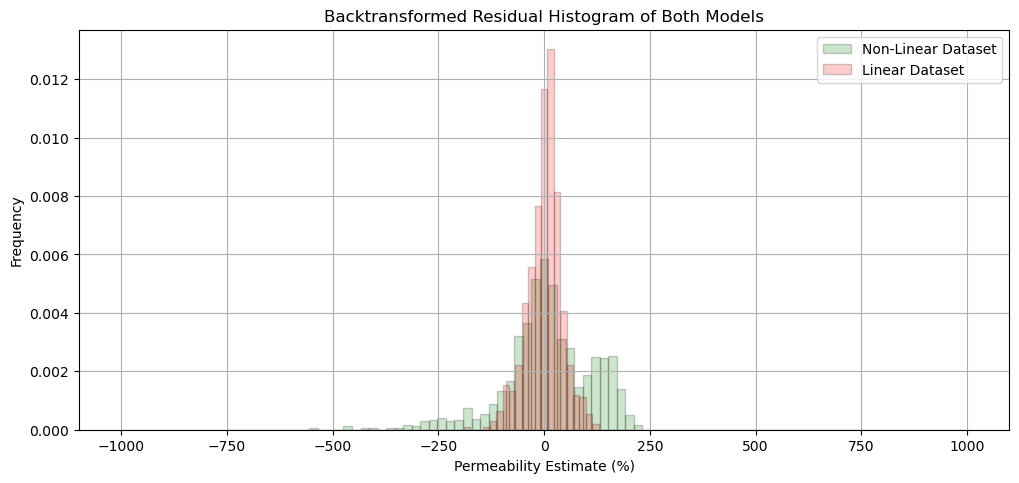

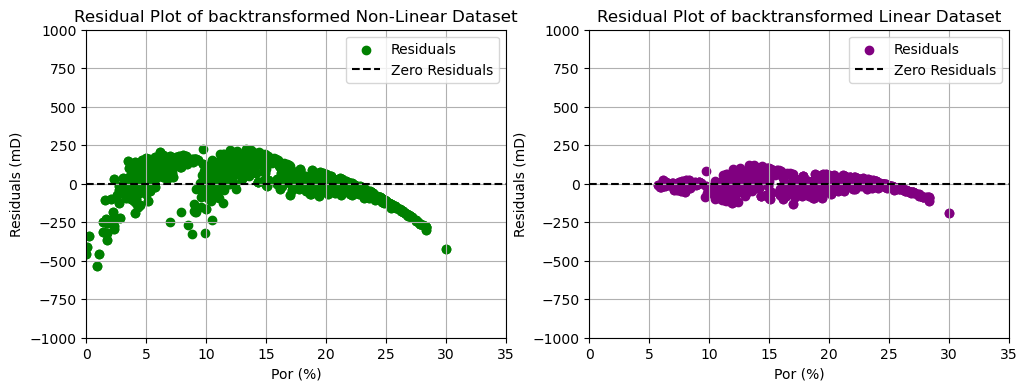

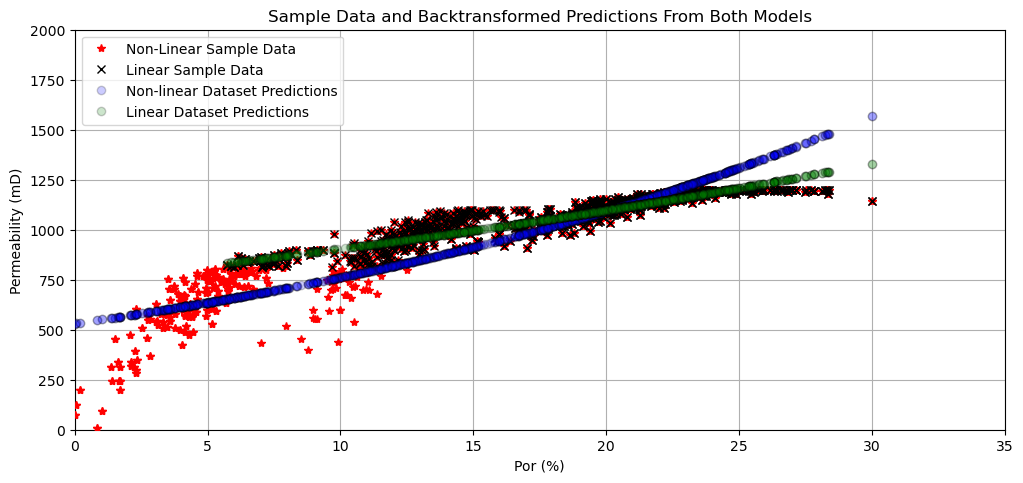

Backtransformed Non-linear dataset mean residual (bias): 7.910994235398377
Backtransformed Non-linear dataset mean squared error: 11666.537
Backtransformed linear dataset mean residual (bias): 0.7484086311434639
Backtransformed linear dataset mean squared error: 1673.6182


In [164]:

TransformedPermeability = np.exp(y_hat)                                # Backtransoforming the non-linear dataset by taking the exponential of the predictions
TransformedPermeability2 = np.exp(y_hat2)                              # Backtransoforming the linear dataset by taking the exponential of the predictions

residual3 = np.exp(y)-TransformedPermeability                          # defining the residuals equation for the non-linear dataset
residual4 = np.exp(y_filtered)- TransformedPermeability2               # defining the residuals equation for the linear dataset

plt.figure(figsize=(9.3,4))                                            # Plotting the backtransformed residuals histogram for both models
plt.subplot(111)
plt.hist(residual3, alpha = 0.2, color = 'green', edgecolor = 'black', bins = np.linspace(-1000,1000,100),label='Non-Linear Dataset', density = True)
plt.hist(residual4, alpha = 0.2, color = 'red', edgecolor = 'black', bins = np.linspace(-750,750,100),label='Linear Dataset', density = True)
plt.title("Backtransformed Residual Histogram of Both Models"); plt.xlabel('Permeability' + ' Estimate (%)');plt.ylabel('Frequency'); plt.grid()
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

plt.figure(figsize=(11.9,4))                                           # Plotting the backtransformed residuals plot for the non-linear model
plt.subplot(121)
plt.scatter(x, residual3, label='Residuals', color='green')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel('Residuals (mD)')
plt.title('Residual Plot of backtransformed Non-Linear Dataset')
plt.legend()
plt.grid(True)
plt.xlim(0,35); plt.ylim(-1000,1000)

plt.subplot(122)                                                       # Plotting the backtransformed residuals plot for the linear model
plt.scatter(x_filtered, residual4, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel('Residuals (mD)')
plt.title('Residual Plot of backtransformed Linear Dataset')
plt.legend()
plt.grid(True)
plt.xlim(0,35); plt.ylim(-1000,1000)
plt.show()

plt.figure(figsize=(9.3,4))                                           # Plotting the backtransformed predictions of both models in addition to the sample data
plt.subplot(111)                                         
plt.plot(x,np.exp(y), '*', label='Non-Linear Sample Data', color = 'red', alpha = 1, markeredgecolor = 'red',zorder=10)
plt.plot(x_filtered,np.exp(y_filtered), 'x', label='Linear Sample Data', color = 'black', alpha = 1, markeredgecolor = 'black',zorder=10)
plt.plot(x,TransformedPermeability, 'o', label='Non-linear Dataset Predictions', color = 'Blue', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.plot(x_filtered,TransformedPermeability2, 'o', label='Linear Dataset Predictions', color = 'green', alpha = 0.2, markeredgecolor = 'black',zorder=10)
plt.title('Sample Data and Backtransformed Predictions From Both Models')
plt.xlabel(xname + ' (' + xunit + ')')
plt.ylabel('Permeability' + ' (' + yunit + ')')
plt.legend(); plt.grid(); plt.xlim([xmin,xmax]); plt.ylim([0,2000])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()


mean_residual3 = residual3.mean()                                    # Calculating the mean of the backtransformed residuals for the non-linear dataset
mean_residual4 = residual4.mean()                                    # Calculating the mean of the backtransformed residuals for the linear dataset

mse3 = mean_squared_error(np.exp(y), np.exp(y_hat))                  # calculating the Mean Squared Error of the backtransformed non-linear dataset
mse4 = mean_squared_error(np.exp(y_filtered), np.exp(y_hat2))        # calculating the Mean Squared Error of the backtransformed linear dataset

print(f"Backtransformed Non-linear dataset mean residual (bias): {mean_residual3}")
print(f"Backtransformed Non-linear dataset mean squared error: {round(mse3,4)}")
print(f"Backtransformed linear dataset mean residual (bias): {mean_residual4}")
print(f"Backtransformed linear dataset mean squared error: {round(mse4,4)}")

#### Discussion
After returning the predictions to the original format, the results show the same conclusion as the transformed one. By comparison, the non-linear dataset displayed predictions more spread away from the zero-residual line, implying higher bias. On the other hand, the histogram of prediction errors for the linear dataset showed a distribution concentrated near zero, pointing to fewer residuals and lower bias. Furthermore, plotting the predictions from both models alongside the original sample data is a clear visual representation of the bias, where the linear dataset predictions clearly fits its data and the non-linear shows clear deviation especially at porosities less than 12% and higher than 23%. In addition, both the mean residual and Mean Squaired Error showed significantly higher values in the non-linear dataset.

In conclusion, the predictions from both the transformed and backtransformed datasets show that fitting a linear regression model in non-linear datasets is a good method to demonstrate bias.

### About me

I am currently a petroleum engineering MSc student at the University of Texas at Austin. Prior to that, I have had experience in the industry and worked as a reservoir engineer, production engineer, and a petrophysicist. I have always had a passion in coding and machine learning and found this course to be a perfect combination to practise that passion that is aligned with my career's experience.

##### Bader Al Shammasi
##### ba27685@my.utexas.edu

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)